In [70]:
import numpy as np
import pandas as pd
from scipy.special import expit
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


### Data Generation
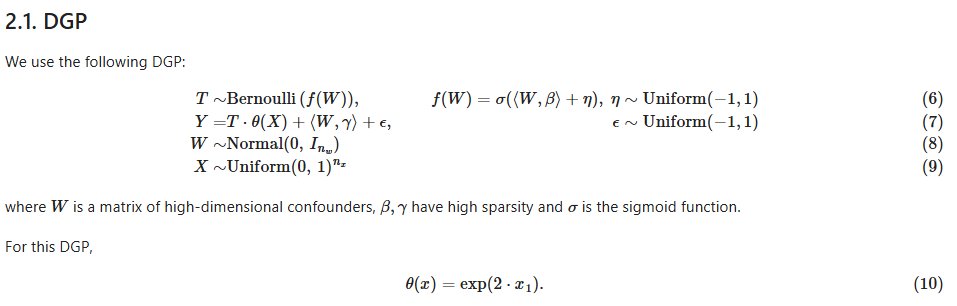


- Treatment Assignment $T$:
    - Binary Treatment
    - If endogenous : Treatment probability determined by a logistic function of confounders $W$
- Outcome $Y$:
    - depends on confounders $W$
    - Treatment EFfect can be heterogenous and depend on features $X$
        - $X$ is a subset of $W$

In [65]:
def ab_test_dgp(
        n_users, 
        n_confounders,
        homogeneous=False,
        endogenous=False, 
        percentage_feature = 0.4, 
        treatment_effect_func=lambda x: np.exp(2 * x[0])):
    
    # Seed
    # np.random.seed(seed)

    # Variables/Confounders
    W = np.random.normal(0, 1, size=(n_users, n_confounders))

    # Treatment Effect
    n_features = max(1, int(n_confounders * percentage_feature))
    X = W[:, np.random.choice(n_confounders, n_features, replace=False)]
    TE = np.array([treatment_effect_func(x_i) for x_i in X])

    if homogeneous:
        TE = np.full_like(TE, TE.mean())

    # Treatment Assignment
    if endogenous:
        beta = np.random.uniform(-1, 1, size=n_confounders)
        eta = np.random.uniform(-1, 1, size=n_users)
        treatment_prob = expit(np.dot(W, beta) + eta)
        T = np.random.binomial(1, treatment_prob)
    else:
        T = np.random.binomial(1, 0.5, n_users)

    # Outcome
    coefs_y = np.random.uniform(0, 1, size=n_confounders)
    epsilon_y = np.random.uniform(-1, 1, size=n_users)
    Y = TE * T + np.dot(W, coefs_y) + epsilon_y

    # Dataframe
    df = pd.DataFrame(W, columns=[f"W{i}" for i in range(1, n_confounders + 1)])
    df['T'] = T
    df['TE'] = TE 
    df['Y'] = Y

    return df
    


In [68]:
df_homo = ab_test_dgp(
    n_users=1000,
    n_confounders=10,
    homogeneous=True
)
df_hetero = ab_test_dgp(
    n_users=1000,
    n_confounders=10,
    homogeneous=False
)

In [83]:
# t-test
def ttest_binary(df):
    y_t = df[df['T'] == 1]['Y']
    y_c = df[df['T'] == 0]['Y']

    y_t_mean = y_t.mean()
    y_c_mean = y_c.mean()

    ate = y_t_mean - y_c_mean
    t_stat, p_value = ttest_ind(y_t, y_c, equal_var=False)
 
    return ate, t_stat, p_value

In [86]:
ate_hetero, _, p_value_hetero = ttest_binary(df_hetero)
print(f"True ATE: {df_hetero['TE'].mean():.4f}")
print(f"ATE: {ate_hetero:.4f}")
print(f"P-Value: {p_value_hetero:.4f}")

True ATE: 5.3838
ATE: 4.8259
P-Value: 0.0000


In [85]:
ate_homo, _, p_value_homo = ttest_binary(df_homo)
print(f"True ATE: {df_homo['TE'].mean():.4f}")
print(f"ATE: {ate_homo:.4f}")
print(f"P-Value: {p_value_homo:.4f}")

True ATE: 5.9352
ATE: 5.7555
P-Value: 0.0000
